https://www.kaggle.com/datasets/wildlifedatasets/seaturtleid2022

In [1]:
import os
import random
import json
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imutils.paths import list_images
from imutils import build_montages
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, Dropout, BatchNormalization,
    GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPooling2D, Flatten,
    Activation, Lambda, concatenate, LeakyReLU
)
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
from google.colab.patches import cv2_imshow
import kagglehub

In [7]:
path = kagglehub.dataset_download("wildlifedatasets/seaturtleid2022")
with open(os.path.join(path, 'turtles-data/data/annotations.json'), 'r') as f:
    data = json.load(f)

In [8]:
images_data = data['images']
df = pd.DataFrame(images_data)

In [13]:
print(df.head)

<bound method NDFrame.head of         id  width  height                    file_name  license flickr_url  \
0        1   2000    1333   images/t001/CAluWEgwPX.JPG        0              
1        2   2000    1333   images/t001/EKyrFKHQzh.JPG        0              
2        3   2000    1333   images/t001/ELAvEqeXxT.JPG        0              
3        4   2000    1124   images/t001/IxRLFwTGCv.JPG        0              
4        5   2000    1333   images/t001/LKCJAhfLBJ.JPG        0              
...    ...    ...     ...                          ...      ...        ...   
8724  8725   2000    1333  images/t610/miUGGSioXO.jpeg        0              
8725  8726   2000    1333  images/t610/aOzTdMCkzF.jpeg        0              
8726  8727   2000    1333  images/t610/ZmTLXySHIZ.jpeg        0              
8727  8728   2000    1333  images/t610/qVDYBLbzda.jpeg        0              
8728  8729   2000    1333  images/t610/THVsdHexWD.jpeg        0              

     coco_url  date_captured     

In [9]:
def extract_label(path):
    return path.split('/')[1]

In [14]:
df['label'] = df['file_name'].apply(extract_label)
print("Unique Labels (Turtles):", df['label'].unique())

Unique Labels (Turtles): ['t001' 't002' 't003' 't004' 't006' 't007' 't008' 't009' 't011' 't013'
 't014' 't015' 't016' 't017' 't018' 't019' 't020' 't021' 't022' 't023'
 't024' 't025' 't026' 't027' 't028' 't029' 't031' 't032' 't033' 't034'
 't035' 't036' 't037' 't038' 't040' 't041' 't042' 't043' 't044' 't045'
 't046' 't048' 't049' 't050' 't051' 't052' 't053' 't055' 't056' 't057'
 't058' 't059' 't060' 't061' 't062' 't063' 't064' 't065' 't066' 't067'
 't068' 't069' 't070' 't071' 't073' 't074' 't075' 't076' 't077' 't078'
 't079' 't080' 't081' 't082' 't083' 't084' 't085' 't086' 't087' 't088'
 't089' 't090' 't091' 't092' 't093' 't094' 't095' 't096' 't097' 't099'
 't101' 't102' 't103' 't104' 't105' 't106' 't107' 't108' 't110' 't112'
 't113' 't114' 't115' 't116' 't118' 't119' 't120' 't121' 't123' 't124'
 't125' 't127' 't128' 't129' 't130' 't131' 't132' 't133' 't135' 't136'
 't137' 't138' 't139' 't140' 't141' 't142' 't143' 't144' 't145' 't146'
 't148' 't149' 't150' 't151' 't152' 't154' 't155' 't

In [35]:
correct_subfolder = "turtles-data/data"
image_paths = [os.path.join(path, correct_subfolder, p) for p in df['file_name']]

labels = df['label'].values

In [38]:
def load_images(image_paths, size=(256, 256)):
    images = []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, size)
            images.append(img)
    return np.array(images)

In [39]:
images = load_images(image_paths)

In [41]:
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

In [42]:
trainX_full, testX_full, trainY_full, testY_full = train_test_split(
    images, labels, test_size=0.2, random_state=42
)

train_indices = np.random.choice(len(trainX_full), 500, replace=False)
test_indices = np.random.choice(len(testX_full), 100, replace=False)

trainX = trainX_full[train_indices]
trainY = trainY_full[train_indices]
testX = testX_full[test_indices]
testY = testY_full[test_indices]

print(f"TrainX shape: {trainX.shape}, TrainY shape: {trainY.shape}")
print(f"TestX shape: {testX.shape}, TestY shape: {testY.shape}")


TrainX shape: (500, 256, 256, 3), TrainY shape: (500,)
TestX shape: (100, 256, 256, 3), TestY shape: (100,)


In [43]:
def make_pairs(images, labels):
    pairImages = []
    pairLabels = []

    label_to_indices = {label: np.where(labels == label)[0] for label in np.unique(labels)}

    for idxA in range(len(images)):
        currentImage = images[idxA]
        label = labels[idxA]

        if len(label_to_indices[label]) > 1:
            posIdx = np.random.choice(label_to_indices[label])
            while posIdx == idxA:
                posIdx = np.random.choice(label_to_indices[label])
            posImage = images[posIdx]

            pairImages.append([currentImage, posImage])
            pairLabels.append(1)

        negLabel = np.random.choice([l for l in label_to_indices.keys() if l != label])
        negIdx = np.random.choice(label_to_indices[negLabel])
        negImage = images[negIdx]

        pairImages.append([currentImage, negImage])
        pairLabels.append(0)

    return (np.array(pairImages), np.array(pairLabels))

In [44]:
(pairTrain, labelTrain) = make_pairs(trainX, trainY)
(pairTest, labelTest) = make_pairs(testX, testY)
print(f"PairTrain shape: {pairTrain.shape}, LabelTrain shape: {labelTrain.shape}")
print(f"PairTest shape: {pairTest.shape}, LabelTest shape: {labelTest.shape}")

PairTrain shape: (882, 2, 256, 256, 3), LabelTrain shape: (882,)
PairTest shape: (131, 2, 256, 256, 3), LabelTest shape: (131,)


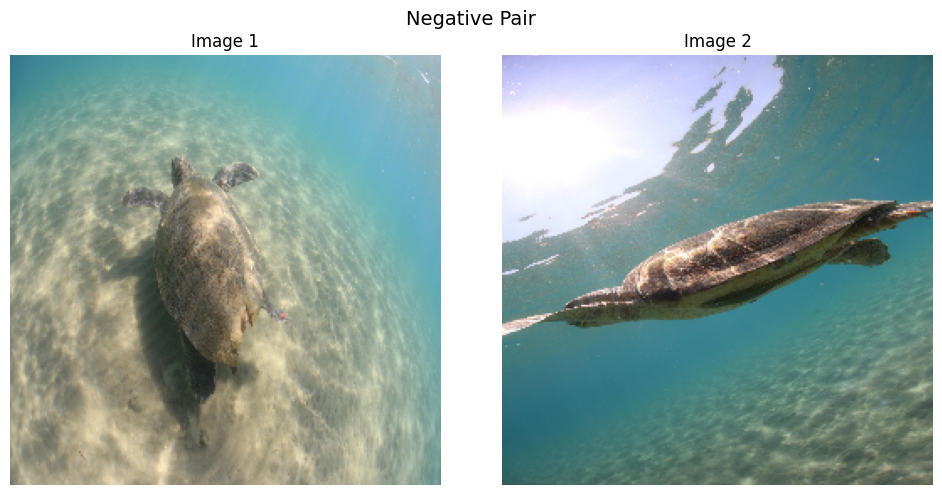

In [45]:
random_index = np.random.randint(0, len(pairTrain))

image1 = pairTrain[random_index][0]
image2 = pairTrain[random_index][1]
pair_label = labelTrain[random_index]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(image1)
plt.title("Image 1")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2)
plt.title("Image 2")
plt.axis('off')

pair_type = "Positive" if pair_label == 1 else "Negative"
plt.suptitle(f"{pair_type} Pair", fontsize=14)

plt.tight_layout()
plt.show()

In [46]:
IMG_SHAPE = (256, 256, 3)
BATCH_SIZE = 16
EPOCHS = 10

In [47]:
def build_siamese_model(inputShape, embeddingDim=128):
    inputs = Input(inputShape)

    x = Conv2D(64, (3, 3), padding="same", kernel_regularizer=l2(1e-4))(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, (3, 3), padding="same", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.3)(x)

    x = Conv2D(256, (3, 3), padding="same", kernel_regularizer=l2(1e-4))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.1)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.4)(x)

    avgPool = GlobalAveragePooling2D()(x)
    maxPool = GlobalMaxPooling2D()(x)
    x = concatenate([avgPool, maxPool])

    x = Dense(embeddingDim, kernel_regularizer=l2(1e-3))(x)
    outputs = Activation("linear")(x)

    model = Model(inputs, outputs)
    return model

In [48]:
def euclidean_distance(vectors):
  (featsA, featsB) = vectors
  sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
  return K.sqrt(K.maximum(sumSquared, K.epsilon()))

In [49]:
def plot_training(H):
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	plt.plot(H.history["val_loss"], label="val_loss")
	plt.plot(H.history["accuracy"], label="train_acc")
	plt.plot(H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	plt.show()

In [50]:
imgA = Input(shape=IMG_SHAPE)
imgB = Input(shape=IMG_SHAPE)
featureExtractor = build_siamese_model(IMG_SHAPE)
featsA = featureExtractor(imgA)
featsB = featureExtractor(imgB)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [51]:
distance = Lambda(euclidean_distance)([featsA, featsB])
outputs = Dense(1, activation="sigmoid")(distance)
model = Model(inputs=[imgA, imgB], outputs=outputs)

In [52]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [53]:
history = model.fit(
	[pairTrain[:, 0], pairTrain[:, 1]], labelTrain[:],
	validation_data=([pairTest[:, 0], pairTest[:, 1]], labelTest[:]),
	batch_size=BATCH_SIZE,
	epochs=EPOCHS)

Epoch 1/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 40s 368ms/step - accuracy: 0.5707 - loss: 5.7262 - val_accuracy: 0.7634 - val_loss: 0.8213
Epoch 2/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.5805 - loss: 1.5348 - val_accuracy: 0.7634 - val_loss: 0.7228
Epoch 3/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.5654 - loss: 1.2359 - val_accuracy: 0.7634 - val_loss: 0.7415
Epoch 4/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.5602 - loss: 1.1182 - val_accuracy: 0.7634 - val_loss: 0.7347
Epoch 5/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.5706 - loss: 0.9947 - val_accuracy: 0.7634 - val_loss: 0.7769
Epoch 6/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.5652 - loss: 0.9793 - val_accuracy: 0.7557 - val_loss: 0.7631
Epoch 7/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.5976 - loss: 0.9088 - val_accuracy: 0.7405 - val_loss: 0.7732
Epoch 8/10
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.5491 - loss: 0.9285 - val_accuracy

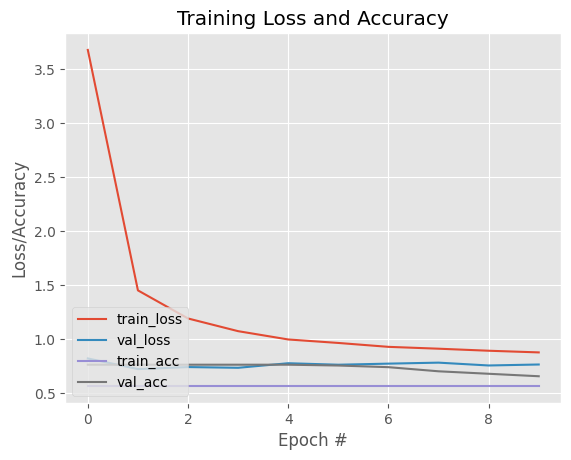

In [54]:
plot_training(history)

In [55]:
model.save("siamese_model.keras")

In [56]:
model = load_model("siamese_model.keras", custom_objects={"euclidean_distance": euclidean_distance})

In [77]:
def generate_test_pairs(df, base_path, num_pairs=5):
    positive_pairs = []
    negative_pairs = []

    folder_to_images = df.groupby('label')['file_name'].apply(list).to_dict()

    for folder, paths in folder_to_images.items():
        if len(paths) > 1:
            for _ in range(num_pairs):
                pathA, pathB = random.sample(paths, 2)
                positive_pairs.append((pathA, pathB))
            if len(positive_pairs) >= num_pairs:
                break

    labels = list(folder_to_images.keys())
    while len(negative_pairs) < num_pairs:
        labelA, labelB = random.sample(labels, 2)
        pathA = random.choice(folder_to_images[labelA])
        pathB = random.choice(folder_to_images[labelB])
        negative_pairs.append((pathA, pathB))

    test_pairs = positive_pairs + negative_pairs
    random.shuffle(test_pairs)
    return test_pairs

In [78]:
num_pairs = 5
test_pairs = generate_test_pairs(df, os.path.join(path, correct_subfolder), num_pairs=num_pairs)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Pair 0: True Label: Negative, Predicted Similarity: 0.44


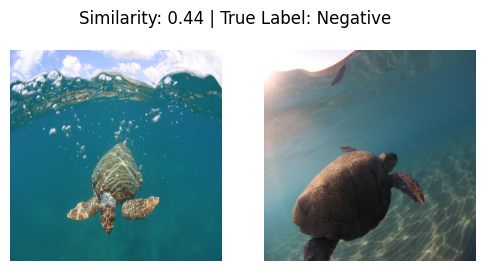

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Pair 1: True Label: Negative, Predicted Similarity: 0.26


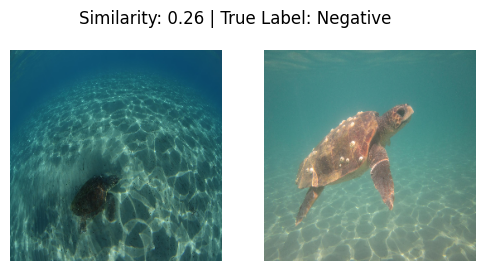

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Pair 2: True Label: Positive, Predicted Similarity: 0.41


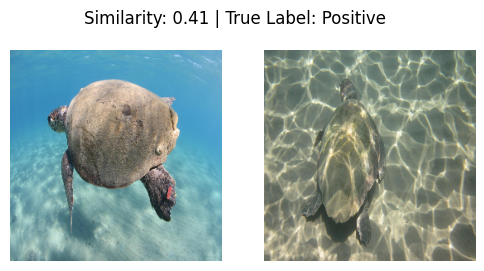

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Pair 3: True Label: Negative, Predicted Similarity: 0.32


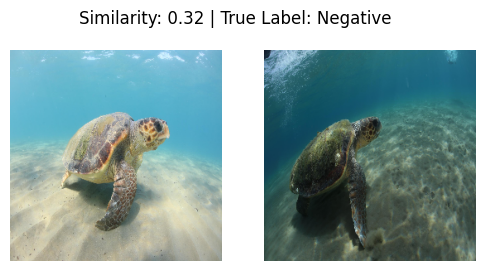

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Pair 4: True Label: Negative, Predicted Similarity: 0.28


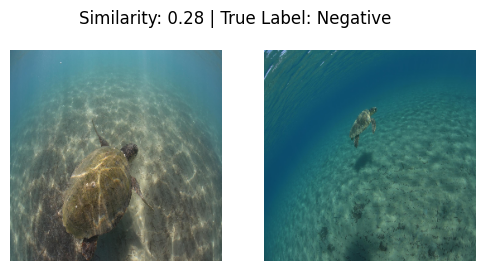

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Pair 5: True Label: Positive, Predicted Similarity: 0.27


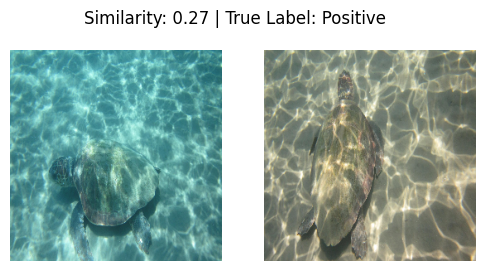

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Pair 6: True Label: Positive, Predicted Similarity: 0.30


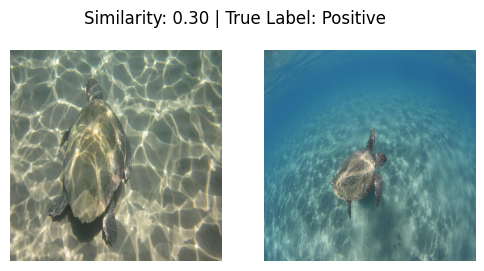

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Pair 7: True Label: Positive, Predicted Similarity: 0.35


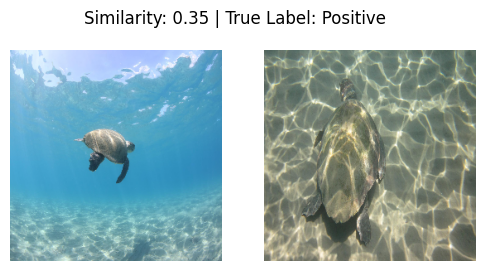

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Pair 8: True Label: Positive, Predicted Similarity: 0.53


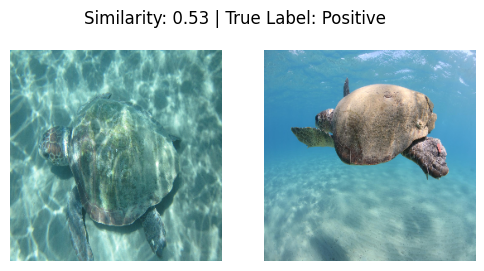

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Pair 9: True Label: Negative, Predicted Similarity: 0.40


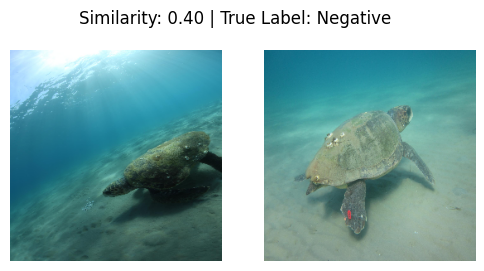

In [79]:
for i, (pathA, pathB) in enumerate(test_pairs):
    labelA = os.path.basename(os.path.dirname(pathA))
    labelB = os.path.basename(os.path.dirname(pathB))
    true_label = "Positive" if labelA == labelB else "Negative"

    imageA = cv2.imread(os.path.join(path, correct_subfolder, pathA))
    imageB = cv2.imread(os.path.join(path, correct_subfolder, pathB))

    imageA = cv2.resize(imageA, (256, 256))
    imageB = cv2.resize(imageB, (256, 256))

    origA = imageA.copy()
    origB = imageB.copy()

    imageA = np.expand_dims(imageA, axis=0)
    imageB = np.expand_dims(imageB, axis=0)

    preds = model.predict([imageA, imageB])
    proba = preds[0][0]

    print(f"Pair {i}: True Label: {true_label}, Predicted Similarity: {proba:.2f}")

    fig = plt.figure(f"Pair #{i + 1}", figsize=(6, 3))
    plt.suptitle(f"Similarity: {proba:.2f} | True Label: {true_label}")

    ax = fig.add_subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(origA, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    ax = fig.add_subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(origB, cv2.COLOR_BGR2RGB))
    plt.axis("off")

    plt.show()